In [1]:
!pip install --upgrade seaborn

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages


In [0]:
import struct

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
from pylab import rcParams
from scipy.special import expit


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]


sns.set(style='whitegrid', palette='colorblind', font_scale=1.5)

rcParams['figure.figsize'] = 10, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [3]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
filenames = [
"train-images-idx3-ubyte.gz",
"t10k-images-idx3-ubyte.gz",
"train-labels-idx1-ubyte.gz",
"t10k-labels-idx1-ubyte.gz"
]

data_dir = "data"

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for f in filenames:
        print(f"Downloading {f}...")
        request.urlretrieve(base_url+f, f"{data_dir}/{f}")
    print("Download complete.")

In [5]:
download_mnist()

Download complete.


In [6]:
!ls data/

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [0]:
def read_mnist(images_path, labels_path):
    """ Read the MNIST dataset from ubyte files """
    with open(labels_path, 'rb') as p:
        magic, n = struct.unpack('>II', p.read(8))
        labels = np.fromfile(p, dtype=np.uint8)
    with open(images_path, 'rb') as p:
        magic, num, rows, cols = struct.unpack(">IIII", p.read(16))
        images = np.fromfile(p, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [0]:
def shuffle_data(features, labels, random_seed=None):
    assert len(features) == len(labels)

    if random_seed:
        np.random.seed(random_seed)
    idx = np.random.permutation(len(features))
    return [a[idx] for a in [features, labels]]

# Background

## The Sigmoid function

The sigmoid function is used quite commonly in the realm of deep learning, at least it was until recently. It has distinct S shape and it is a differentiable real function for any real input value. Additionally, it has a positive derivative at each point. More importantly, we will use it as an activation function for the hidden layer of our model. Here's how it is defined:

$$\sigma (x) = \frac{1}{1+e^{-x}}$$

It’s first derivative (which we will use during the backpropagation step of our training algorithm) has the following formula:

$$\dfrac{d}{dx}\sigma(x) = \sigma(x)(1 - \sigma(x))$$

So, the derivative can be expressed using the original sigmoid function. Pretty cool, eh? Here is a more detailed derivation (thanks to [Mike Percy](https://math.stackexchange.com/a/1225116/)):

$$
\begin{align}
\dfrac{d}{dx} \sigma(x) &= \dfrac{d}{dx} \left[ \dfrac{1}{1 + e^{-x}} \right] \\
&= \dfrac{d}{dx} \left( 1 + \mathrm{e}^{-x} \right)^{-1} \\
&= -(1 + e^{-x})^{-2}(-e^{-x}) \\
&= \dfrac{e^{-x}}{\left(1 + e^{-x}\right)^2} \\
&= \dfrac{1}{1 + e^{-x}\ } \cdot \dfrac{e^{-x}}{1 + e^{-x}}  \\
&= \dfrac{1}{1 + e^{-x}\ } \cdot \dfrac{(1 + e^{-x}) - 1}{1 + e^{-x}}  \\
&= \dfrac{1}{1 + e^{-x}\ } \cdot \left( \dfrac{1 + e^{-x}}{1 + e^{-x}} - \dfrac{1}{1 + e^{-x}} \right) \\
&= \dfrac{1}{1 + e^{-x}\ } \cdot \left( 1 - \dfrac{1}{1 + e^{-x}} \right) \\
&= \sigma(x) \cdot (1 - \sigma(x))
\end{align}
$$

Proof of why $\dfrac{d}{dx}e^x = e^x$ can be found [here](https://www.khanacademy.org/math/in-in-grade-11-ncert/in-in-class11-differentiation/copy-of-sine-and-cosine-derivatives-ab/v/proof-of-derivative-of-ex). Don’t like formulas? Let’s look at a picture:



In [0]:
def sigmoid(z):
    # return 1.0 / (1.0 + np.exp(-z))
    return expit(z)


def sigmoid_prime(z):
    sg = sigmoid(z)
    return sg * (1 - sg)

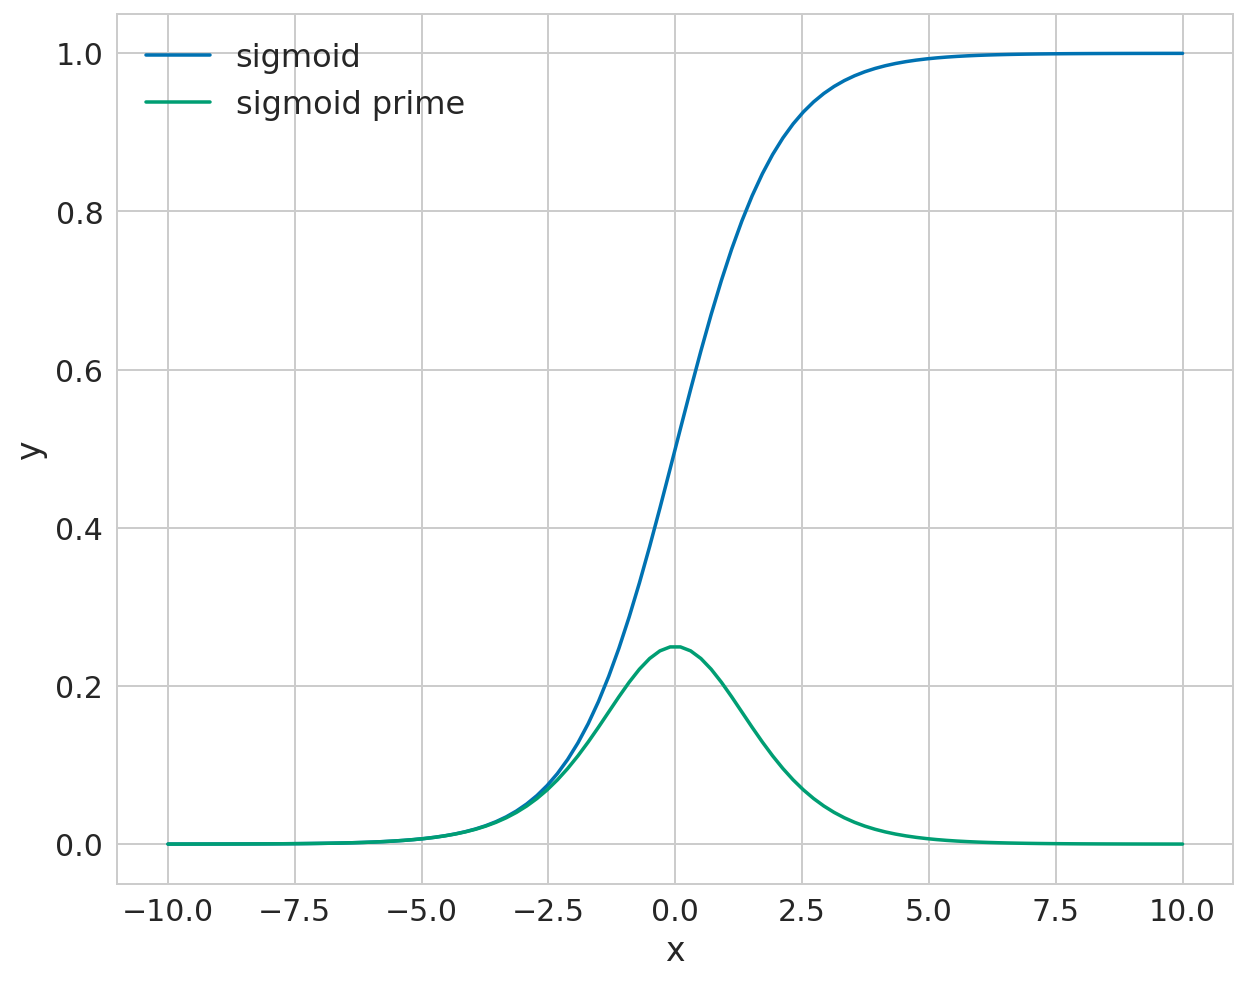

In [10]:
x = np.linspace(-10., 10., num=100)
sig = sigmoid(x)
sig_prime = sigmoid_prime(x)

plt.plot(x, sig, label="sigmoid")
plt.plot(x, sig_prime, label="sigmoid prime")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(prop={'size' : 16})
plt.show()

The derivative shows us the rate of change of a function. We can use it to determine the “slope” of that function. The highest rate of change for the sigmoid function is when $x=0$, as it is evident from the derivative graph (in green).

## Softmax

The softmax function can be easily differentiated, it is pure (output depends only on input) and the elements of the resulting vector sum to 1. Here it is:

$$\sigma(z)_j = \frac{e^{z_j}}{\sum_{K}^{k=1}e^{z_k}} \text{for}\,j = 1,...,k$$

In probability theory, the output of the softmax function is sometimes used as a representation of a categorical distribution. Let’s see an example result:

In [0]:
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [12]:
softmax(np.array([[2, 4, 6, 8]]))

array([[0.00214401, 0.0158422 , 0.11705891, 0.86495488]])

The output has most of its weight corresponding to the input 8. The softmax function highlights the largest value(s) and suppresses the smaller ones.

## Backpropagation

Backpropagation is the backbone of almost anything we do when using Neural Networks. The algorithm consists of 3 subtasks:

- Make a forward pass
- Calculate the error
- Make backward pass (backpropagation)

In the first step, backprop uses the data and the weights of the network to compute a prediction. Next, the error is computed based on the prediction and the provided labels. The final step propagates the error through the network, starting from the final layer. Thus, the weights get updated based on the error, little by little.

# Learning the XOR function

Let's try to create a Neural Network (NN) with 1 hidden layer that can properly predict values from the `XOR` function. Here is the truth table:

| A 	| B 	| Output 	|
|---	|---	|--------	|
| 0 	| 0 	| 0      	|
| 0 	| 1 	| 1      	|
| 1 	| 0 	| 1      	|
| 1 	| 1 	| 0      	|

Visually, we have:

![XOR function](http://curiousily.com/assets/15.tensorflow_for_hackers_part_4_files/xor.png)

## Data

We will use the data from the truth table above and convert it to numpy arrays:

In [0]:
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([ [0],   [1],   [1],   [0]])

## Setup

Let's define our Neural Net structure, learning rate and for how long we're going to train it:

In [0]:
epochs = 50000
input_size, hidden_size, output_size = 2, 3, 1
learning_rate = 0.1

Let's have a look at our Neural Net:

![](http://outlace.com/images/grad_descent/XORNeuralNet.png)

[Source](http://outlace.com/Gradient-Descent.html)

We have 2 weight matrices $\Theta_1$ and $\Theta_2$ holding the weight values between the input/hidden layer and hidden/output layer, respectively.

## Weight Initialization

We will initialize the weight of our NN using small random numbers:

In [0]:
Theta_hidden = np.random.uniform(size=(input_size, hidden_size))
Theta_output = np.random.uniform(size=(hidden_size, output_size))

### Untrained NN performance

Let's have a look at what our model can predict while it is still untrained:

In [0]:
# @author Denny Britz http://blog.dennybritz.com/
def plot_decision_boundary(pred_func, y):
  
  # Set min and max values and give it some padding
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
  h = 0.01
  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  # Predict the function value for the whole gid
  Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  # Plot the contour and training examples
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

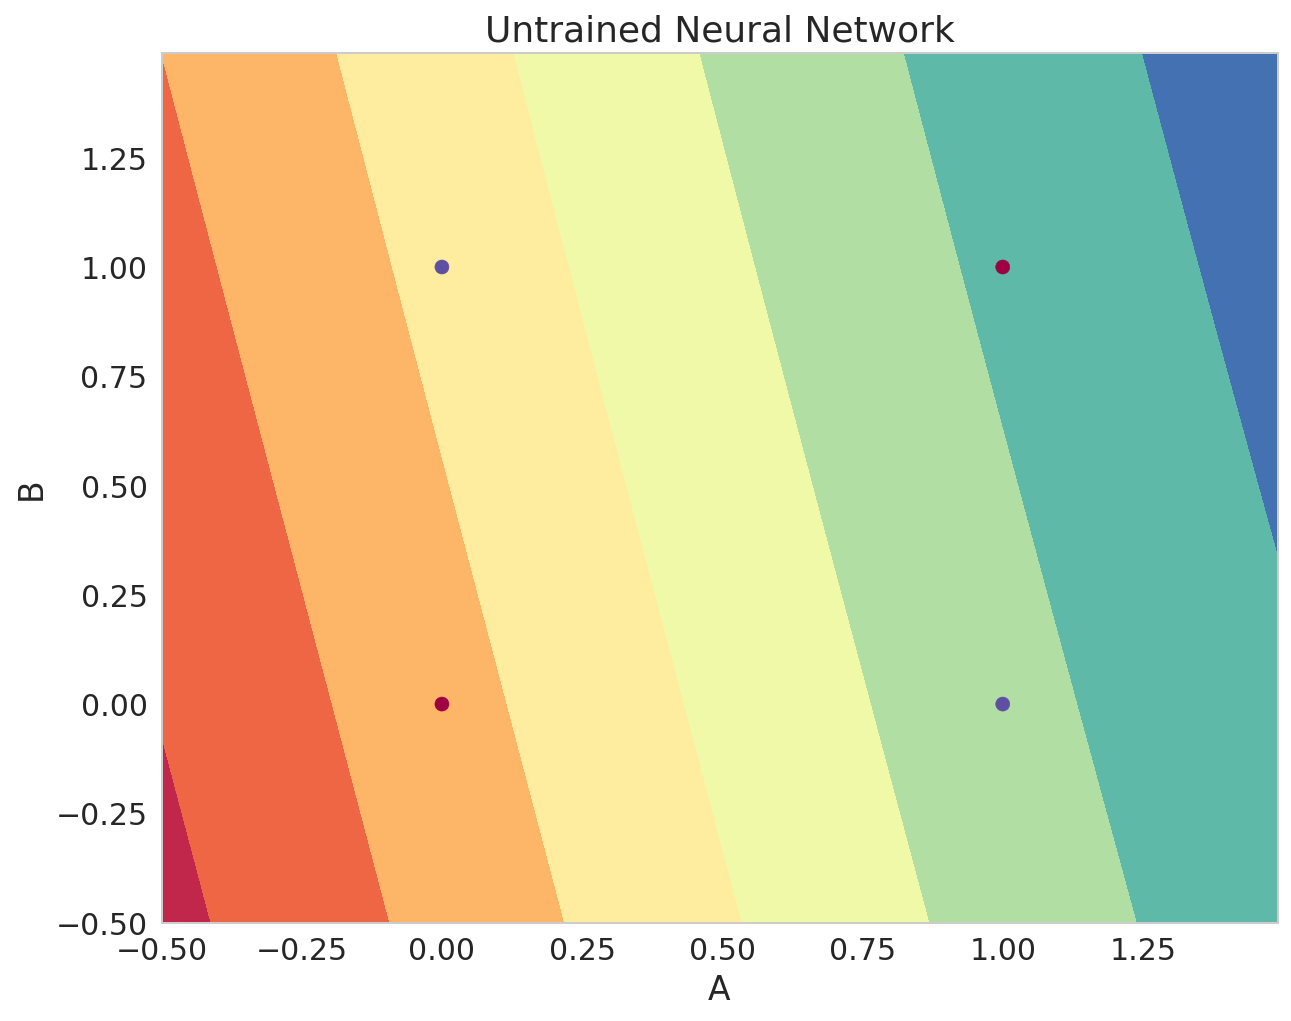

In [18]:
def predict_untrained(X):
  global Theta_hidden, Theta_output
  act_hidden = sigmoid(np.dot(X, Theta_hidden))
  return np.dot(act_hidden, Theta_output)

plot_decision_boundary(lambda x: predict_untrained(x), y.squeeze())
plt.xlabel("A")
plt.ylabel("B")
plt.title("Untrained Neural Network");
plt.show();

## Training

Finally, it is time to implement the **Backpropagation** algorithm:

### Loss function

First, let's define our loss function which will simply subtract the predicted label from the true one:

In [0]:
def criterion(y_hat, y):
  return y - y_hat

### Backpropagation

We can now train our model via the Backpropagation algorihm. It is time to use those derivates:

In [20]:
for epoch in range(epochs):
  
  # Forward pass (forward method in PyTorch modules)
  
  hidden_activation = sigmoid(np.dot(X, Theta_hidden))
  y_hat = np.dot(hidden_activation, Theta_output)
  
  # Calculate the error between the predictions and real values
  
  loss = criterion(y_hat, y)
  
  # Backward pass - use the error to nudge the weights of our NN so that it can make better predictions (layer by layer)
  
  delta_output = learning_rate * loss
  
  Theta_output += hidden_activation.T.dot(delta_output)
  
  delta_hidden = delta_output.dot(Theta_output.T) * sigmoid_prime(hidden_activation)
  
  Theta_hidden += X.T.dot(delta_hidden)
    
  if epoch % 5000 == 0:
    print(f'epoch {epoch}: error {np.mean(loss)}')

epoch 0: error -0.44374003998462475
epoch 5000: error 0.001466412518818322
epoch 10000: error 0.001314247471488686
epoch 15000: error 9.062613449728474e-05
epoch 20000: error -0.00016164294643256083
epoch 25000: error 0.00047382994733019546
epoch 30000: error 9.477546220049149e-09
epoch 35000: error 1.8540724511240114e-13
epoch 40000: error 3.3029134982598407e-15
epoch 45000: error 3.3029134982598407e-15


The backward pass works like this:

- Starting at the output neurons, we calculate their delta, $\delta$. Delta's represent the error for each node in the network. The delta of the output neuron is simply $\delta_1 = (h(x) - y)$ which is the output of the output neuron minus the real value $y$.

- To calculate the previous layer's delta, we backpropagate the deltas using the formula:

$$\delta_j^{l-1} = (\theta_2 . \delta_j^l) \odot (a^{l-1} \odot (1 - a^{l-1}))$$

where $.$ is dot product, $\odot$ is element-wise multiplication and $l$ is the number of layers



## Prediction

Our error seems to be decreasing! Let's try to use our trained model for prediction, doing just a forward step:

In [0]:
def predict(X):
  hidden_activation = sigmoid(np.dot(X, Theta_hidden))
  return np.dot(hidden_activation, Theta_output)

In [22]:
X_test = X[1] # [0, 1]

predict(X_test)

array([1.])

Hmm, that seems correct!

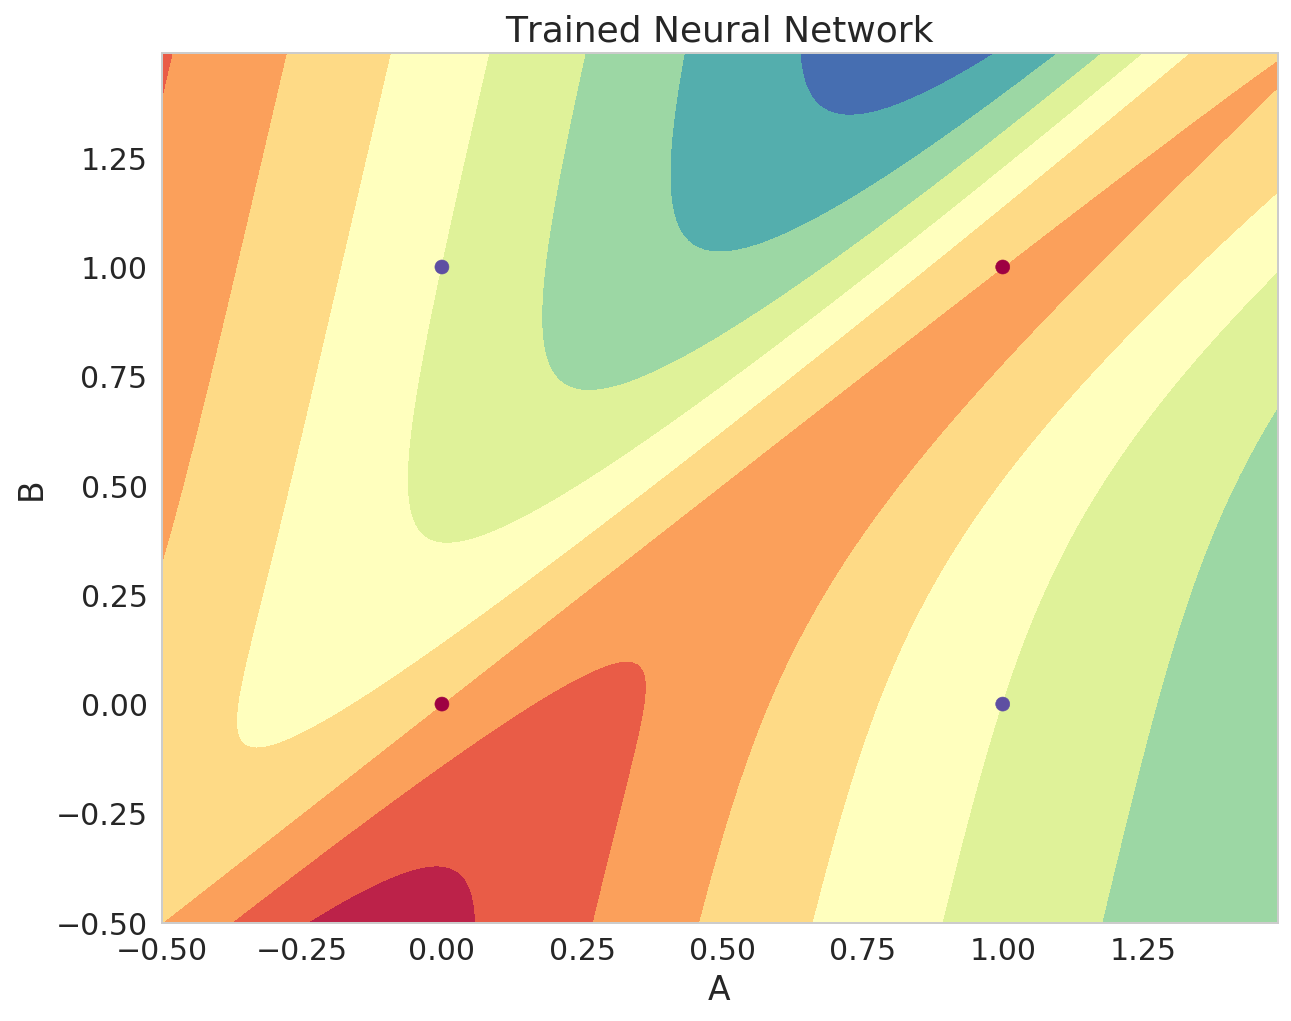

In [23]:
plot_decision_boundary(lambda x: predict(x), y.squeeze())
plt.xlabel("A")
plt.ylabel("B")
plt.title("Trained Neural Network");
plt.show();